In [2]:
pip install ucimlrepo

In [3]:
# Student Performance Dataset Analysis with Neural Networks - Improved Version
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [4]:

# Set consistent visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
color_palette = sns.color_palette("muted")

# Fetch dataset
student_performance = fetch_ucirepo(id=320)

# Extract data
X = student_performance.data.features
y = student_performance.data.targets

# Print dataset information
print("==== Dataset Metadata ====")
print(student_performance.metadata)
print("\n==== Variables Information ====")
print(student_performance.variables)


==== Dataset Metadata ====
{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annu

# ======**EXPLORATORY DATA ANALYSIS** ============

In [5]:

print("\n==== EXPLORATORY DATA ANALYSIS ====")

# Basic information about the dataset
print("\nFeatures shape:", X.shape)
print("Targets shape:", y.shape)

# Summary statistics of features
print("\nFeatures summary statistics:")
print(X.describe())

# Summary statistics of targets
print("\nTargets summary statistics:")
print(y.describe())

# Check for missing values
print("\nMissing values in features:")
print(X.isna().sum())
print("\nMissing values in targets:")
print(y.isna().sum())

# Create a more complete dataset that includes G1 and G2
# Since these are strong predictors of G3 and would be available in real-world scenarios
merged_data = pd.concat([X, y], axis=1)



==== EXPLORATORY DATA ANALYSIS ====

Features shape: (649, 30)
Targets shape: (649, 3)

Features summary statistics:
              age        Medu        Fedu  traveltime   studytime    failures  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean    16.744222    2.514638    2.306626    1.568567    1.930663    0.221880   
std      1.218138    1.134552    1.099931    0.748660    0.829510    0.593235   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    1.000000    1.000000    1.000000    0.000000   
50%     17.000000    2.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.

# ===================== **FEATURE ENGINEERING** =====================


In [6]:

print("\n==== FEATURE ENGINEERING ====")

# Create new features
merged_data['absences_squared'] = merged_data['absences'] ** 2
merged_data['age_squared'] = merged_data['age'] ** 2
merged_data['failures_squared'] = merged_data['failures'] ** 2

# Create interaction features
merged_data['study_failures'] = merged_data['studytime'] * (4 - merged_data['failures'])
merged_data['freetime_goout'] = merged_data['freetime'] - merged_data['goout']

# Create categorical feature based on age groups
merged_data['age_group'] = pd.cut(
    merged_data['age'],
    bins=[0, 16, 18, 22],
    labels=['<16', '16-18', '>18']
)



==== FEATURE ENGINEERING ====


# ===================== **DATA VISUALIZATION** =====================



==== DATA VISUALIZATION ====


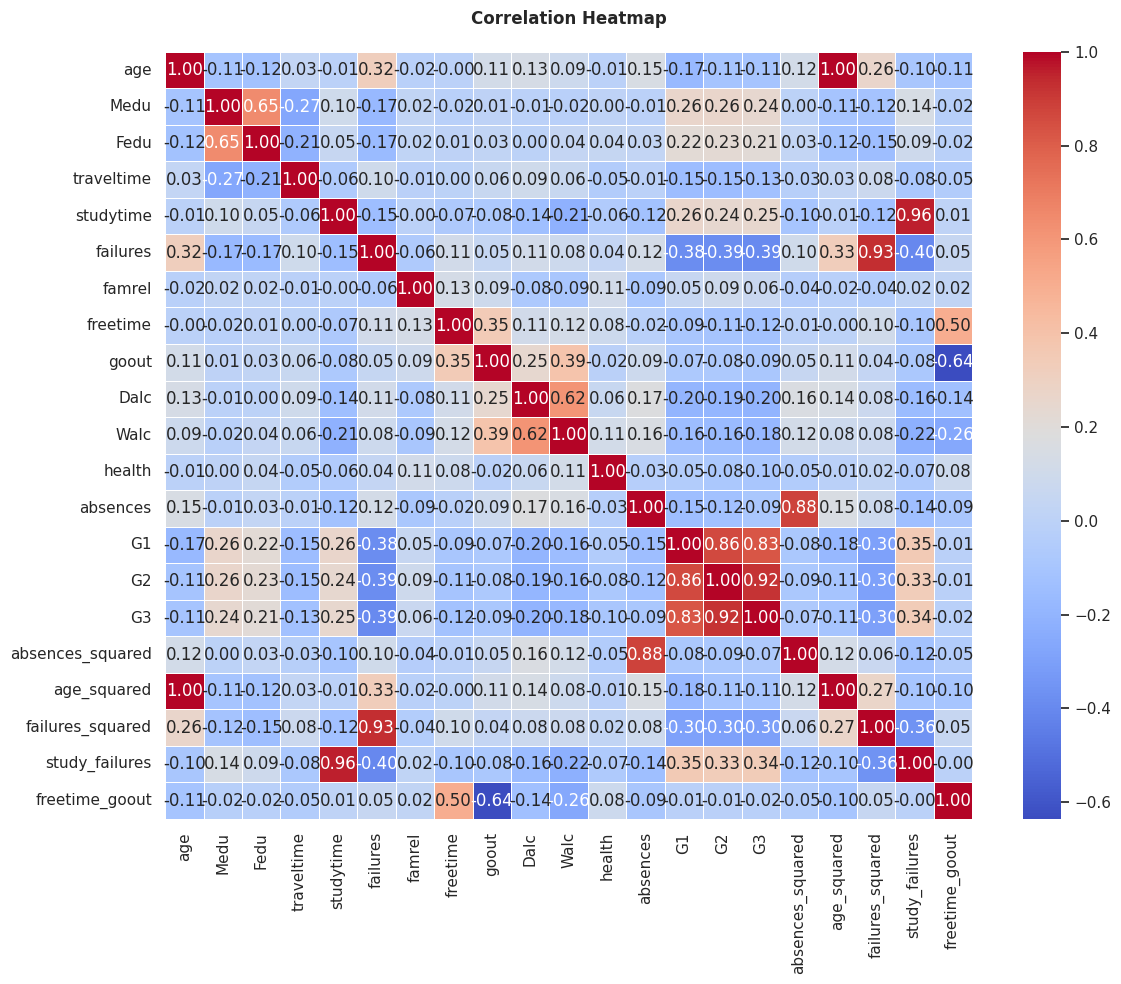

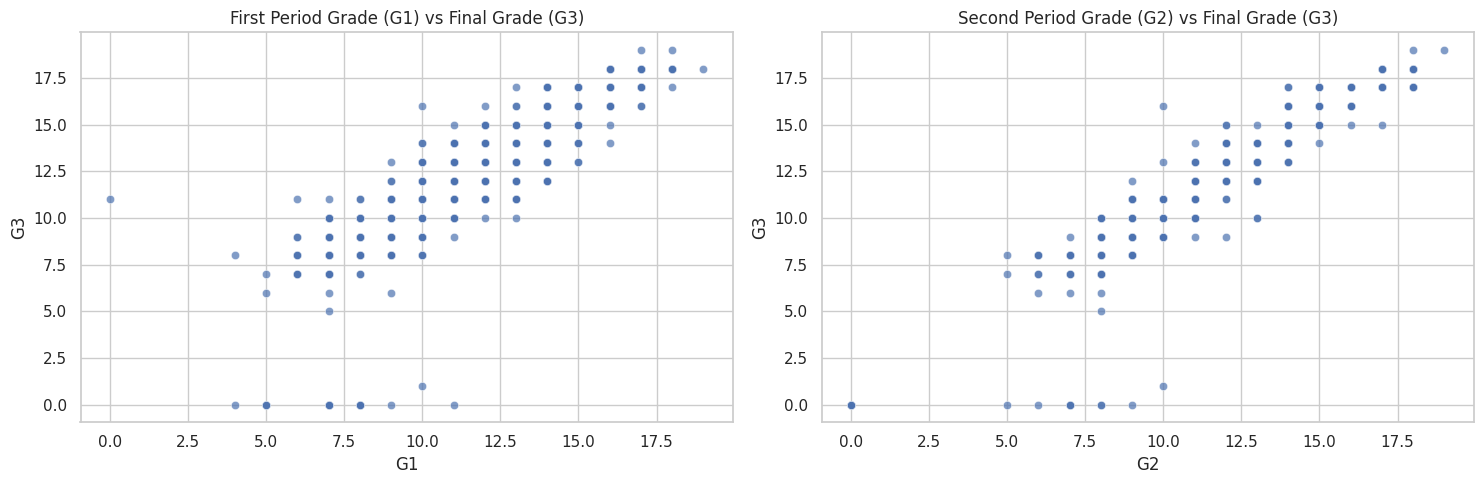


==== MODEL WITH G1 AND G2 AS PREDICTORS ====

Categorical columns: 18
Numerical columns: 20

Preprocessed feature dimensions after selection: 30


In [7]:

print("\n==== DATA VISUALIZATION ====")

# Helper function for consistent plot styling
def style_plot(ax, title, xlabel, ylabel):
    ax.set_title(title, fontweight='bold', pad=20)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Create a figure for correlation visualization
fig, ax = plt.subplots(figsize=(12, 10))

# Focus especially on correlation between G1, G2, and G3
numeric_cols = merged_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr_matrix = merged_data[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', ax=ax)
ax.set_title('Correlation Heatmap', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Plot G1, G2, and G3 relationships
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='G1', y='G3', data=merged_data, alpha=0.7)
plt.title("First Period Grade (G1) vs Final Grade (G3)")
plt.xlabel("G1")
plt.ylabel("G3")

plt.subplot(1, 2, 2)
sns.scatterplot(x='G2', y='G3', data=merged_data, alpha=0.7)
plt.title("Second Period Grade (G2) vs Final Grade (G3)")
plt.xlabel("G2")
plt.ylabel("G3")

plt.tight_layout()
plt.show()

# Define a model with G1 and G2 as predictors
print("\n==== MODEL WITH G1 AND G2 AS PREDICTORS ====")
X_with_grades = merged_data.drop(columns=['G3'])
y_target = merged_data['G3']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_with_grades, y_target, test_size=0.2, random_state=42
)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', PowerTransformer(method='yeo-johnson'), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Feature selection to keep only the most relevant features
selector = SelectKBest(f_regression, k=min(30, X_train_processed.shape[1]))
X_train_processed = selector.fit_transform(X_train_processed, y_train)
X_test_processed = selector.transform(X_test_processed)

print(f"\nPreprocessed feature dimensions after selection: {X_train_processed.shape[1]}")

# Convert data to tensors
X_train_tensor = torch.FloatTensor(X_train_processed)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_processed)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

# Create DataLoader with a smaller batch size
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Function to calculate regression "accuracy" (predictions within ±1 and ±2 of target)
def regression_accuracy(y_true, y_pred):
    y_pred_rounded = np.round(y_pred)  # Round predictions to nearest integer
    within_1 = np.mean(np.abs(y_true - y_pred_rounded) <= 1)
    within_2 = np.mean(np.abs(y_true - y_pred_rounded) <= 2)
    exact_match = np.mean(np.abs(y_true - y_pred_rounded) < 0.5)
    return exact_match, within_1, within_2

# Function to create prediction vs actual plots
def plot_prediction_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 8))

    # Round predictions to make the visualization more meaningful
    y_pred_rounded = np.round(y_pred)

    # Add jitter to avoid overlapping points
    jitter = np.random.normal(0, 0.1, size=len(y_true))
    y_true_jitter = y_true + jitter

    # Plot the scatter plot
    plt.scatter(y_true_jitter, y_pred, alpha=0.6, color=color_palette[0])

    # Plot the perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    # Add +/- 1 and +/- 2 guide lines
    plt.plot([min_val, max_val], [min_val+1, max_val+1], 'g--', alpha=0.5)
    plt.plot([min_val, max_val], [min_val-1, max_val-1], 'g--', alpha=0.5)
    plt.plot([min_val, max_val], [min_val+2, max_val+2], 'b--', alpha=0.3)
    plt.plot([min_val, max_val], [min_val-2, max_val-2], 'b--', alpha=0.3)

    plt.title(f'Predicted vs Actual Grades - {model_name}', fontweight='bold')
    plt.xlabel('Actual Grade')
    plt.ylabel('Predicted Grade')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name, criterion, optimizer, scheduler=None, num_epochs=200, early_stopping=True):
    loss_history = []
    best_loss = float('inf')
    patience = 20
    patience_counter = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss/len(train_loader)
        loss_history.append(epoch_loss)

        if scheduler:
            scheduler.step(epoch_loss)

        # Early stopping logic
        if early_stopping:
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    model.load_state_dict(best_model_state)
                    break

        if (epoch+1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Load best model if early stopping was used
    if early_stopping and best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        y_pred = y_pred.numpy().flatten()

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        exact, acc_1, acc_2 = regression_accuracy(y_test.values, y_pred)

    print(f"\nModel Results ({model_name}):")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Exact Match Accuracy: {exact:.4f} ({exact*100:.2f}%)")
    print(f"Accuracy (within ±1 grade): {acc_1:.4f} ({acc_1*100:.2f}%)")
    print(f"Accuracy (within ±2 grades): {acc_2:.4f} ({acc_2*100:.2f}%)")

    # Create evaluation plots
    plot_prediction_vs_actual(y_test.values, y_pred, model_name)

    return model, y_pred, mse, mae, r2, exact, acc_1, acc_2, loss_history


# ===================== **MODEL 1: SIMPLE ANN** =====================



==== MODEL 1: ENHANCED SIMPLE ANN ====
Epoch [20/300], Loss: 5.0654
Epoch [40/300], Loss: 4.3552
Epoch [60/300], Loss: 3.3101
Epoch [80/300], Loss: 2.6653
Epoch [100/300], Loss: 2.8628
Early stopping at epoch 111

Model Results (Enhanced Simple ANN):
Mean Squared Error: 1.8900
Mean Absolute Error: 0.9083
R² Score: 0.8062
Exact Match Accuracy: 0.3923 (39.23%)
Accuracy (within ±1 grade): 0.8385 (83.85%)
Accuracy (within ±2 grades): 0.9538 (95.38%)


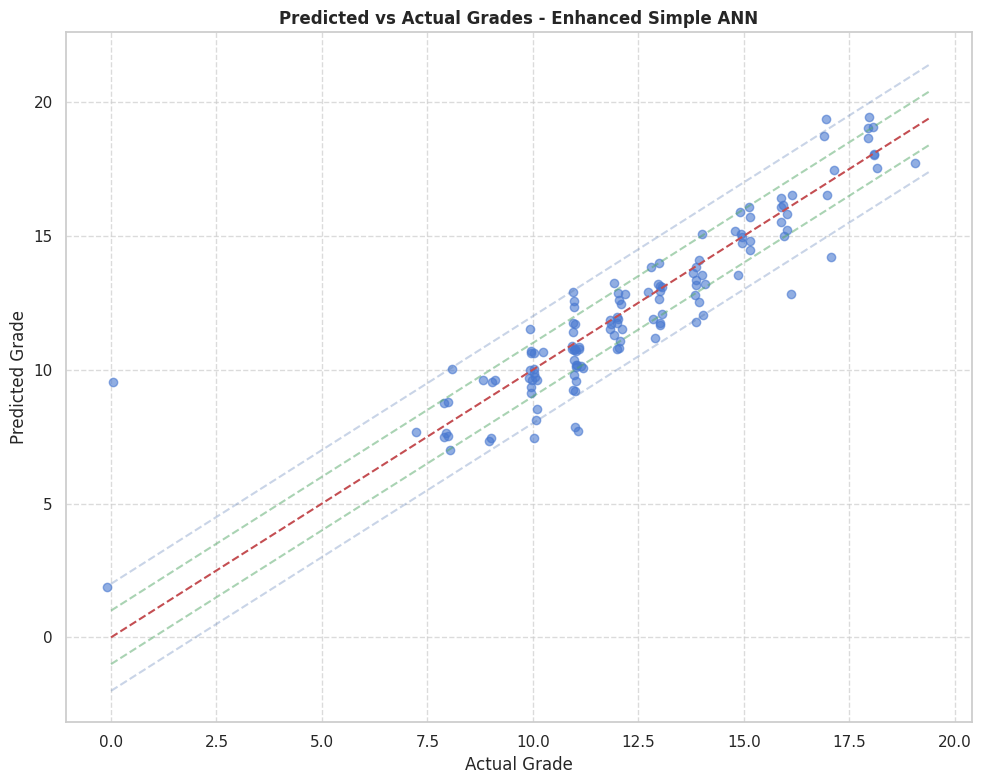

In [8]:

print("\n==== MODEL 1: ENHANCED SIMPLE ANN ====")

# Define the model
class EnhancedSimpleANN(nn.Module):
    def __init__(self, input_size):
        super(EnhancedSimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.LeakyReLU(0.1)
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.LeakyReLU(0.1)
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Initialize the model
input_size = X_train_processed.shape[1]
model_simple = EnhancedSimpleANN(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_simple.parameters(), lr=0.001, weight_decay=1e-5)

# Train and evaluate
model_simple, y_pred_simple, mse_simple, mae_simple, r2_simple, exact_simple, acc_1_simple, acc_2_simple, loss_simple = train_and_evaluate_model(
    model_simple, "Enhanced Simple ANN", criterion, optimizer, num_epochs=300)


# ===================== **MODEL 2: MEDIUM ANN** =====================



==== MODEL 2: ADVANCED MEDIUM ANN ====


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [20/300], Loss: 0.8716
Epoch [40/300], Loss: 0.7895
Epoch [60/300], Loss: 0.7031
Early stopping at epoch 67

Model Results (Advanced Medium ANN):
Mean Squared Error: 2.0638
Mean Absolute Error: 0.9615
R² Score: 0.7884
Exact Match Accuracy: 0.3538 (35.38%)
Accuracy (within ±1 grade): 0.7692 (76.92%)
Accuracy (within ±2 grades): 0.9615 (96.15%)


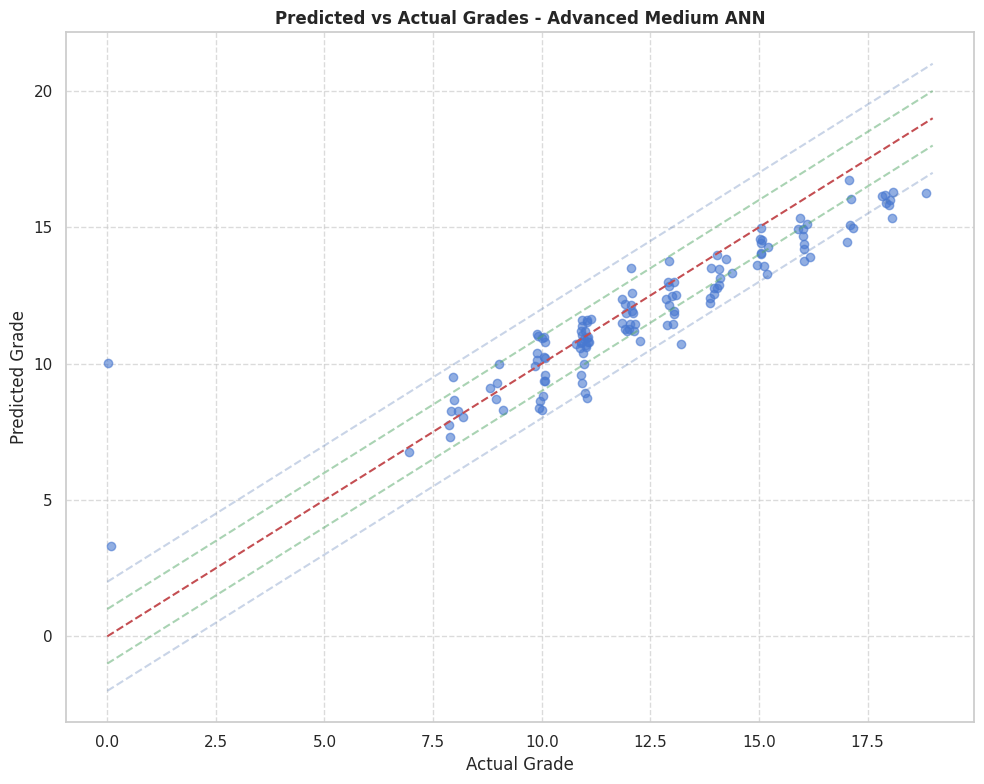

In [9]:

print("\n==== MODEL 2: ADVANCED MEDIUM ANN ====")

# Define the model
class AdvancedMediumANN(nn.Module):
    def __init__(self, input_size):
        super(AdvancedMediumANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.LeakyReLU(0.1)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.LeakyReLU(0.1)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.relu3 = nn.LeakyReLU(0.1)

        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.bn1(self.fc1(x))))
        x = self.dropout2(self.relu2(self.bn2(self.fc2(x))))
        x = self.relu3(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

# Initialize the model
model_medium = AdvancedMediumANN(input_size)

# Define loss function and optimizer
criterion = nn.HuberLoss(delta=1.0)  # Huber loss for robustness to outliers
optimizer = optim.AdamW(model_medium.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Train and evaluate
model_medium, y_pred_medium, mse_medium, mae_medium, r2_medium, exact_medium, acc_1_medium, acc_2_medium, loss_medium = train_and_evaluate_model(
    model_medium, "Advanced Medium ANN", criterion, optimizer, scheduler, num_epochs=300)


# ===================== **MODEL 3: RESIDUAL ANN** =====================



==== MODEL 3: RESIDUAL NETWORK ANN ====


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [20/400], Loss: 2.1573
Epoch [40/400], Loss: 1.6230
Epoch [60/400], Loss: 1.5877
Epoch [80/400], Loss: 1.0271
Epoch [100/400], Loss: 1.1038
Epoch [120/400], Loss: 1.0100
Epoch [140/400], Loss: 0.8559
Epoch [160/400], Loss: 1.0054
Early stopping at epoch 164

Model Results (Residual Network ANN):
Mean Squared Error: 1.6973
Mean Absolute Error: 0.8624
R² Score: 0.8260
Exact Match Accuracy: 0.4462 (44.62%)
Accuracy (within ±1 grade): 0.8769 (87.69%)
Accuracy (within ±2 grades): 0.9769 (97.69%)


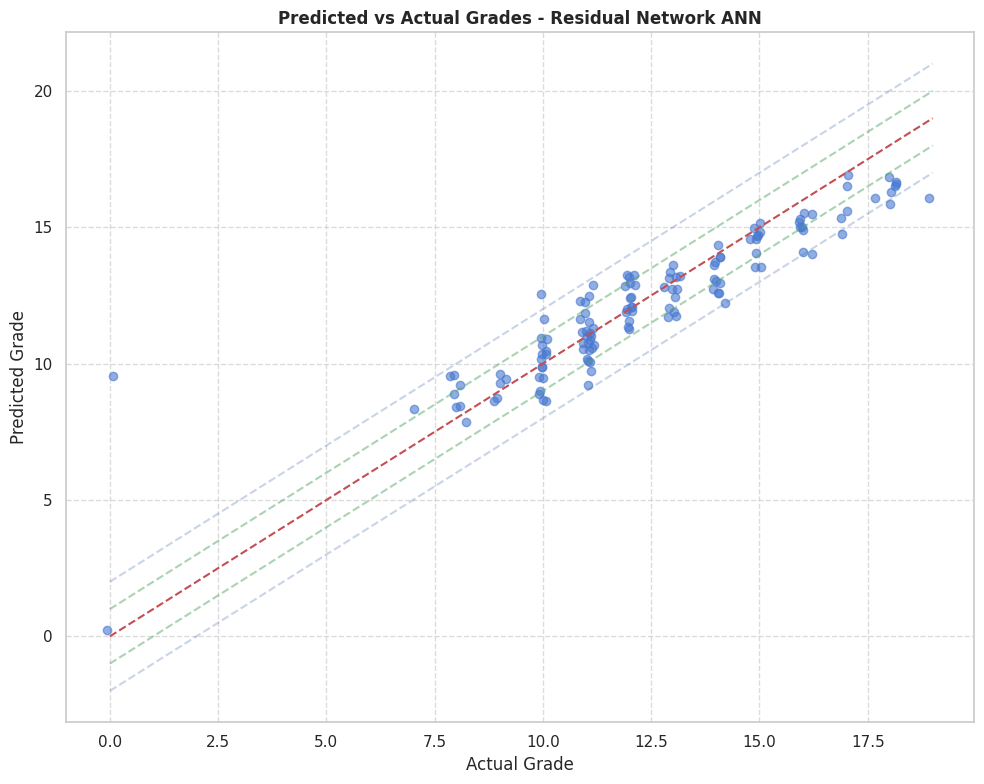

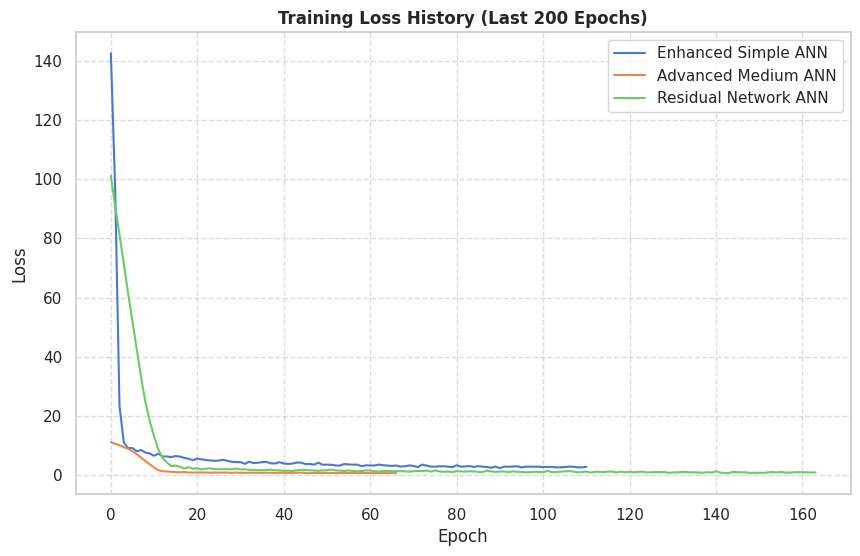

In [10]:

print("\n==== MODEL 3: RESIDUAL NETWORK ANN ====")

# Define the model with residual connections
class ResidualANN(nn.Module):
    def __init__(self, input_size):
        super(ResidualANN, self).__init__()
        # First block
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.LeakyReLU(0.1)
        self.dropout1 = nn.Dropout(0.2)

        # Second block with residual connection
        self.fc2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.LeakyReLU(0.1)
        self.dropout2 = nn.Dropout(0.2)

        # Third block
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.relu3 = nn.LeakyReLU(0.1)

        # Fourth block with residual connection
        self.fc4 = nn.Linear(64, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.relu4 = nn.LeakyReLU(0.1)

        # Output layers
        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.relu5 = nn.LeakyReLU(0.1)
        self.fc6 = nn.Linear(32, 1)

    def forward(self, x):
        # First block
        out1 = self.dropout1(self.relu1(self.bn1(self.fc1(x))))

        # Second block with residual connection
        out2 = self.dropout2(self.relu2(self.bn2(self.fc2(out1))))
        out2 = out1 + out2  # Residual connection

        # Third block
        out3 = self.relu3(self.bn3(self.fc3(out2)))

        # Fourth block with residual connection
        out4 = self.relu4(self.bn4(self.fc4(out3)))
        out4 = out3 + out4  # Residual connection, shapes must match

        # Output layers
        out5 = self.relu5(self.bn5(self.fc5(out4)))
        out = self.fc6(out5)
        return out

# Initialize the model
model_residual = ResidualANN(input_size)

# Custom loss function combining MSE and MAE for better accuracy
class CombinedLoss(nn.Module):
    def __init__(self, mse_weight=0.7, mae_weight=0.3):
        super(CombinedLoss, self).__init__()
        self.mse_weight = mse_weight
        self.mae_weight = mae_weight
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()

    def forward(self, pred, target):
        return self.mse_weight * self.mse(pred, target) + self.mae_weight * self.mae(pred, target)

# Define loss function and optimizer
criterion = CombinedLoss(mse_weight=0.7, mae_weight=0.3)
optimizer = optim.AdamW(model_residual.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

# Train and evaluate
model_residual, y_pred_residual, mse_residual, mae_residual, r2_residual, exact_residual, acc_1_residual, acc_2_residual, loss_residual = train_and_evaluate_model(
    model_residual, "Residual Network ANN", criterion, optimizer, scheduler, num_epochs=400)

# Plot training loss histories
plt.figure(figsize=(10, 6))
plt.plot(loss_simple[-200:], label='Enhanced Simple ANN', color=color_palette[0])
plt.plot(loss_medium[-200:], label='Advanced Medium ANN', color=color_palette[1])
plt.plot(loss_residual[-200:], label='Residual Network ANN', color=color_palette[2])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History (Last 200 Epochs)', fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# ===================== **MODEL COMPARISON** =====================



==== MODEL COMPARISON ====
                  Model       MSE       MAE  R² Score  Exact Match  \
0   Enhanced Simple ANN  1.889983  0.908295  0.806190     0.392308   
1   Advanced Medium ANN  2.063794  0.961495  0.788366     0.353846   
2  Residual Network ANN  1.697254  0.862424  0.825953     0.446154   

   Accuracy (±1)  Accuracy (±2)  
0       0.838462       0.953846  
1       0.769231       0.961538  
2       0.876923       0.976923  


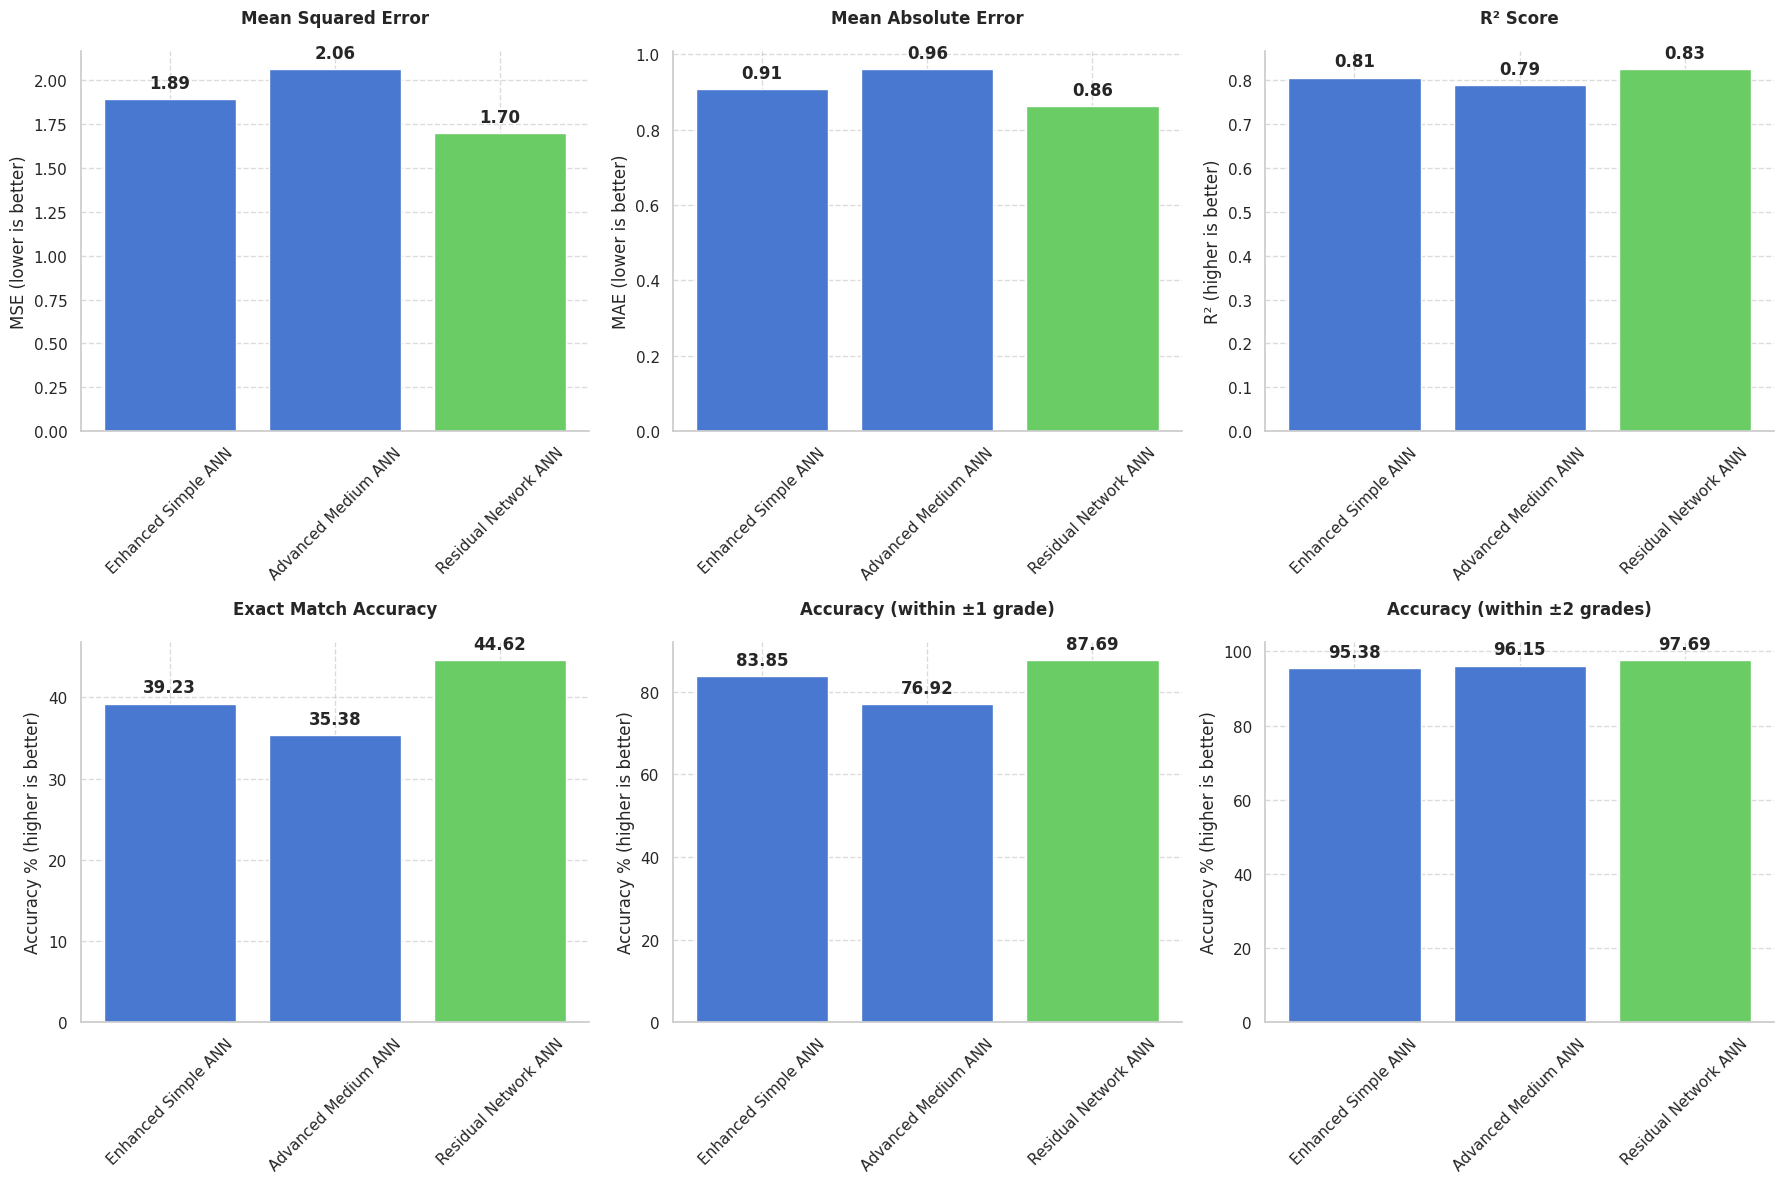

In [11]:

print("\n==== MODEL COMPARISON ====")

results = pd.DataFrame({
    'Model': ['Enhanced Simple ANN', 'Advanced Medium ANN', 'Residual Network ANN'],
    'MSE': [mse_simple, mse_medium, mse_residual],
    'MAE': [mae_simple, mae_medium, mae_residual],
    'R² Score': [r2_simple, r2_medium, r2_residual],
    'Exact Match': [exact_simple, exact_medium, exact_residual],
    'Accuracy (±1)': [acc_1_simple, acc_1_medium, acc_1_residual],
    'Accuracy (±2)': [acc_2_simple, acc_2_medium, acc_2_residual]
})

print(results)

# Plot model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

metrics = ['MSE', 'MAE', 'R² Score', 'Exact Match', 'Accuracy (±1)', 'Accuracy (±2)']
titles = ['Mean Squared Error', 'Mean Absolute Error', 'R² Score',
          'Exact Match Accuracy', 'Accuracy (within ±1 grade)', 'Accuracy (within ±2 grades)']
y_labels = ['MSE (lower is better)', 'MAE (lower is better)', 'R² (higher is better)',
            'Accuracy % (higher is better)', 'Accuracy % (higher is better)', 'Accuracy % (higher is better)']
better_dir = ['lower', 'lower', 'higher', 'higher', 'higher', 'higher']

# Create bar plots for each metric
for i, (metric, title, ylabel, direction) in enumerate(zip(metrics, titles, y_labels, better_dir)):
    row, col = i // 3, i % 3
    ax = axes[row, col]

    # For accuracy metrics, convert to percentage
    if 'Accuracy' in metric or 'Exact' in metric:
        values = results[metric] * 100
    else:
        values = results[metric]

    # Use different colors based on whether higher or lower is better
    if direction == 'lower':
        colors = [color_palette[2] if v == min(values) else color_palette[0] for v in values]
    else:
        colors = [color_palette[2] if v == max(values) else color_palette[0] for v in values]

    bars = ax.bar(results['Model'], values, color=colors)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02*max(values),
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

    style_plot(ax, title, '', ylabel)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# ==========**ALL MODELS COMPARISON PLOT** ==================


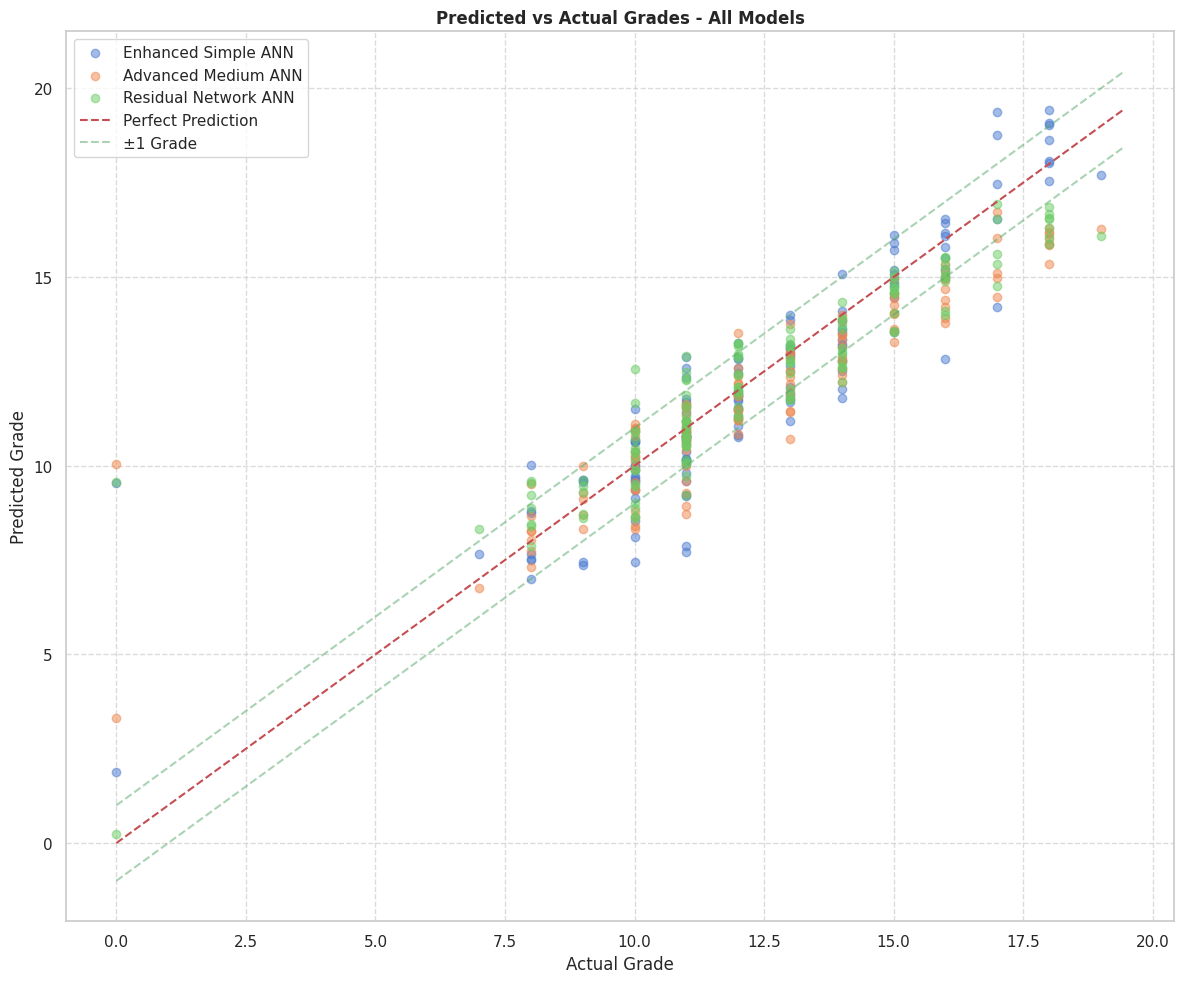


Analysis completed with improved model architectures and feature engineering.


In [12]:

# Combined prediction vs actual plot for all models
plt.figure(figsize=(12, 10))

plt.scatter(y_test, y_pred_simple, alpha=0.5, color=color_palette[0], label='Enhanced Simple ANN')
plt.scatter(y_test, y_pred_medium, alpha=0.5, color=color_palette[1], label='Advanced Medium ANN')
plt.scatter(y_test, y_pred_residual, alpha=0.5, color=color_palette[2], label='Residual Network ANN')

# Plot the perfect prediction line
min_val = min(y_test.min(), min(y_pred_simple.min(), y_pred_medium.min(), y_pred_residual.min()))
max_val = max(y_test.max(), max(y_pred_simple.max(), y_pred_medium.max(), y_pred_residual.max()))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

# Add +/- 1 guide lines
plt.plot([min_val, max_val], [min_val+1, max_val+1], 'g--', alpha=0.5, label='±1 Grade')
plt.plot([min_val, max_val], [min_val-1, max_val-1], 'g--', alpha=0.5)

plt.title('Predicted vs Actual Grades - All Models', fontweight='bold')
plt.xlabel('Actual Grade')
plt.ylabel('Predicted Grade')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nAnalysis completed with improved model architectures and feature engineering.")